<a href="https://colab.research.google.com/github/mdapoy/Machine-Learning-week-8-16/blob/main/Ch3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PENJELASAN AWAL

Chapter 3 dari buku "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow" bergeser fokus dari regresi ke klasifikasi, salah satu tugas pembelajaran terawasi (supervised learning) yang paling umum. Penulis, Aurélien Géron, menggunakan dataset MNIST yang terkenal untuk memperkenalkan dan mendalami berbagai metrik kinerja penting untuk klasifikasi.

## TUJUAN

Tujuan utama dari bab ini adalah untuk memperkenalkan konsep klasifikasi dan metrik evaluasi yang relevan, terutama ketika berhadapan dengan skewed datasets. Pembaca akan belajar cara melatih pengklasifikasi biner dan multikelas, serta cara menganalisis kinerjanya menggunakan berbagai metrik.

## Ringkasan Konten Utama

Chapter ini membahas topik-topik kunci dalam klasifikasi:

### 1.MNIST Dataset

- Pengenalan Dataset: Dataset MNIST adalah kumpulan 70.000 gambar kecil digit tulisan tangan (28x28 piksel), yang dilabeli dengan digit yang diwakilinya (0-9). Ini sering disebut sebagai "hello world" dalam Machine Learning untuk tugas klasifikasi.
- Memuat Data: Scikit-Learn menyediakan fungsi fetch_openml() untuk memuat dataset MNIST. Data dimuat sebagai objek mirip kamus dengan kunci data (fitur), target (label), dan DESCR (deskripsi).
- Struktur Data: Setiap gambar direpresentasikan sebagai vektor 784 fitur (28 * 28 piksel), dengan intensitas piksel dari 0 hingga 255. Label target awalnya adalah string, tetapi diubah menjadi integer (np.uint8) karena sebagian besar algoritma ML mengharapkan angka.
- Pemisahan Data: Dataset sudah terbagi menjadi training set (60.000 gambar) dan test set (10.000 gambar). Penulis menekankan bahwa training set sudah diacak, yang penting untuk memastikan cross-validation folds serupa dan untuk menghindari bias urutan pada beberapa algoritma pembelajaran.

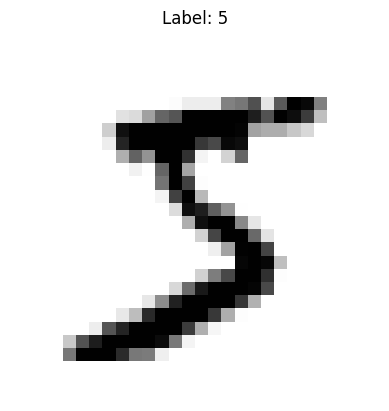

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Memuat dataset MNIST
mnist = fetch_openml('mnist_784', version=1, parser='auto') # Tambahkan parser='auto'
X, y = mnist["data"], mnist["target"]

# Mengubah label ke integer
y = y.astype(np.uint8)

# Memisahkan training dan test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Menampilkan salah satu digit (opsional)
some_digit = X.iloc[0].values # Menggunakan .iloc[0].values untuk DataFrame
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.title(f"Label: {y[0]}")
plt.show()

### 2.Training a Binary Classifier (Melatih Pengklasifikasi Biner)

- Penyederhanaan Masalah: Masalah disederhanakan menjadi pengklasifikasi biner, misalnya, "5-detector" yang membedakan digit 5 dari digit bukan-5.
- Target Biner: Vektor target baru (y_train_5, y_test_5) dibuat di mana True untuk digit 5 dan False untuk digit lainnya.
- Stochastic Gradient Descent (SGD) Classifier: SGDClassifier dari Scikit-Learn dipilih sebagai pengklasifikasi awal karena kemampuannya menangani dataset besar secara efisien dan sifat online learning-nya.

In [2]:
from sklearn.linear_model import SGDClassifier

# Membuat target biner (apakah digit 5 atau bukan)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Melatih SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Membuat prediksi untuk some_digit
print(f"\nPrediction for the first digit (is it a 5?): {sgd_clf.predict([X_train.iloc[0].values])}")


Prediction for the first digit (is it a 5?): [ True]


### 3.Performance Measures (Metrik Kinerja)

Evaluasi pengklasifikasi jauh lebih rumit daripada regresi.
- Measuring Accuracy Using Cross-Validation (Mengukur Akurasi Menggunakan Cross-Validation):
  - cross_val_score() dari Scikit-Learn digunakan untuk mengevaluasi SGDClassifier menggunakan K-fold cross-validation (dengan 3 folds).
  - SGDClassifier menunjukkan akurasi di atas 93%.
  - Kelemahan Akurasi: Sebuah pengklasifikasi "bodoh" yang selalu memprediksi "bukan-5" juga dapat mencapai akurasi lebih dari 90% karena dataset MNIST sangat skewed (hanya sekitar 10% gambar adalah digit 5). Ini menunjukkan bahwa akurasi bukanlah metrik yang disukai untuk dataset yang skewed.

In [3]:
from sklearn.model_selection import cross_val_score

# Evaluasi SGDClassifier dengan cross-validation
sgd_scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"\nSGDClassifier Cross-Validation Accuracy Scores: {sgd_scores}")

# Pengklasifikasi 'bodoh' yang selalu memprediksi bukan-5
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
never_5_scores = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"Never5Classifier Cross-Validation Accuracy Scores: {never_5_scores}")


SGDClassifier Cross-Validation Accuracy Scores: [0.95035 0.96035 0.9604 ]
Never5Classifier Cross-Validation Accuracy Scores: [0.91125 0.90855 0.90915]


- Confusion Matrix (Matriks Kebingungan):
  - Cara yang lebih baik untuk mengevaluasi pengklasifikasi.
  - Untuk menghitung matriks kebingungan, cross_val_predict() digunakan untuk mendapatkan "prediksi bersih" pada training set (prediksi dibuat oleh model yang tidak melihat data selama pelatihan).
  - confusion_matrix() kemudian digunakan dengan target dan prediksi.
  - Setiap baris merepresentasikan kelas aktual, dan setiap kolom merepresentasikan kelas prediksi.
  - Matriks kebingungan memiliki empat kategori: True Negatives (TN), False Positives (FP), False Negatives (FN), dan True Positives (TP).

In [4]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
conf_mx = confusion_matrix(y_train_5, y_train_pred)
print(f"\nConfusion Matrix for SGDClassifier:\n{conf_mx}")

# Matriks kebingungan untuk pengklasifikasi sempurna (ilustrasi)
y_train_perfect_predictions = y_train_5
print(f"Confusion Matrix for Perfect Classifier:\n{confusion_matrix(y_train_5, y_train_perfect_predictions)}")


Confusion Matrix for SGDClassifier:
[[53892   687]
 [ 1891  3530]]
Confusion Matrix for Perfect Classifier:
[[54579     0]
 [    0  5421]]


- Precision and Recall (Presisi dan Recall):
  - Precision: Akurasi prediksi positif. Rumus:
  - 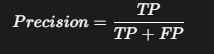
  - Recall (Sensitivity / True Positive Rate): Rasio instansi positif yang terdeteksi dengan benar. Rumus:
  - 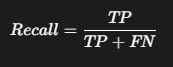
  - Scikit-Learn menyediakan fungsi precision_score() dan recall_score().
  - F1 Score: Rata-rata harmonis dari precision dan recall, berguna untuk membandingkan pengklasifikasi. Rumus:
  - 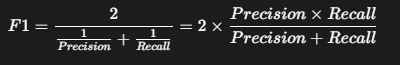
  - F1 score tinggi hanya jika precision dan recall keduanya tinggi. Pilihan metrik ini bergantung pada konteks masalah (misalnya, precision tinggi untuk video anak-anak, recall tinggi untuk deteksi pengutil).



In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"\nPrecision Score for SGDClassifier: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall Score for SGDClassifier: {recall_score(y_train_5, y_train_pred)}")
print(f"F1 Score for SGDClassifier: {f1_score(y_train_5, y_train_pred)}")


Precision Score for SGDClassifier: 0.8370879772350012
Recall Score for SGDClassifier: 0.6511713705958311
F1 Score for SGDClassifier: 0.7325171197343847


- Precision/Recall Trade-off (Trade-off Presisi/Recall):
  - Meningkatkan precision akan mengurangi recall, dan sebaliknya.
  - SGDClassifier membuat keputusan klasifikasi berdasarkan nilai fungsi keputusan (decision function) dan threshold.
  - decision_function() digunakan untuk mendapatkan skor keputusan alih-alih prediksi.
  - precision_recall_curve() digunakan untuk menghitung precision dan recall untuk semua threshold yang mungkin.
  - Visualisasi kurva precision vs recall sebagai fungsi dari threshold membantu memilih trade-off yang sesuai.
  - Contoh: Mencapai precision 90% akan secara signifikan menurunkan recall.

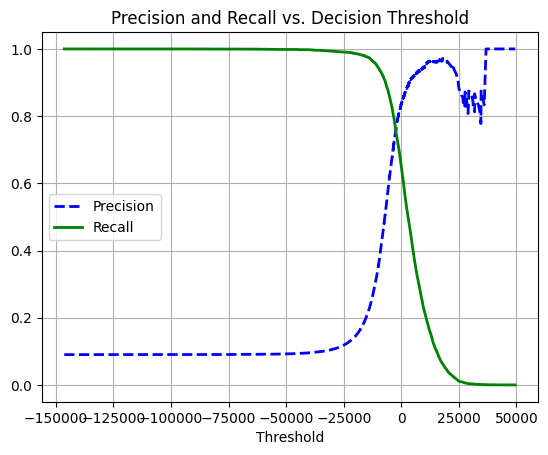

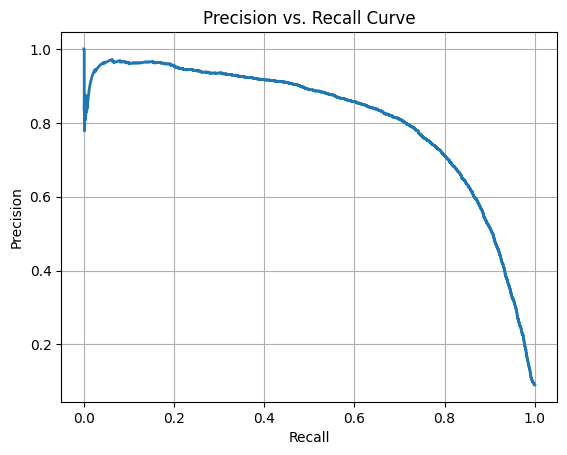


Precision at 90% threshold: 0.9000345901072293
Recall at 90% threshold: 0.4799852425751706


In [6]:
# Mendapatkan skor keputusan
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Fungsi untuk memplot kurva Precision/Recall vs Threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.grid(True)
    plt.title("Precision and Recall vs. Decision Threshold")
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# Plot Precision vs Recall
plt.plot(recalls, precisions, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.title("Precision vs. Recall Curve")
plt.show()

# Mencari threshold untuk precision 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(f"\nPrecision at 90% threshold: {precision_score(y_train_5, y_train_pred_90)}")
print(f"Recall at 90% threshold: {recall_score(y_train_5, y_train_pred_90)}")

- The ROC Curve (Kurva ROC):
  - Receiver Operating Characteristic (ROC) curve adalah alat lain untuk pengklasifikasi biner.
  - Kurva ROC memplot True Positive Rate (TPR, alias recall) terhadap False Positive Rate (FPR).
  - FPR adalah rasio instansi negatif yang salah diklasifikasikan sebagai positif, setara dengan 1 - True Negative Rate (TNR, alias specificity).
  - roc_curve() digunakan untuk menghitung TPR dan FPR.
  - Pengklasifikasi yang baik akan memiliki kurva ROC yang jauh dari garis diagonal acak, menuju sudut kiri atas.
  - ROC AUC Score: Area Under the Curve (AUC) ROC digunakan untuk membandingkan pengklasifikasi. Pengklasifikasi sempurna memiliki AUC 1, pengklasifikasi acak memiliki AUC 0.5.
  - ROC vs PR Curve: PR curve lebih disukai ketika kelas positif langka atau ketika false positives lebih penting daripada false negatives. Jika tidak, gunakan kurva ROC.

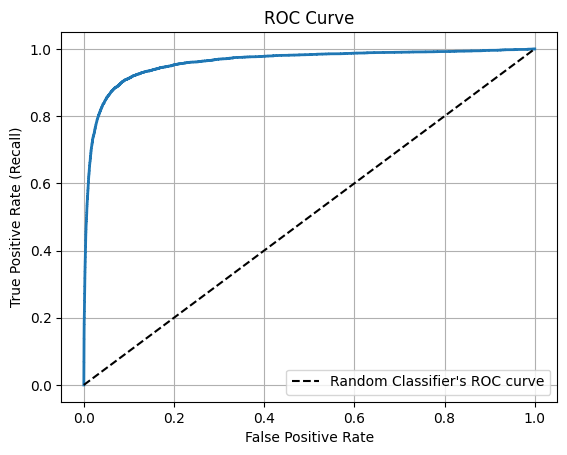


ROC AUC Score for SGDClassifier: 0.9604938554008616


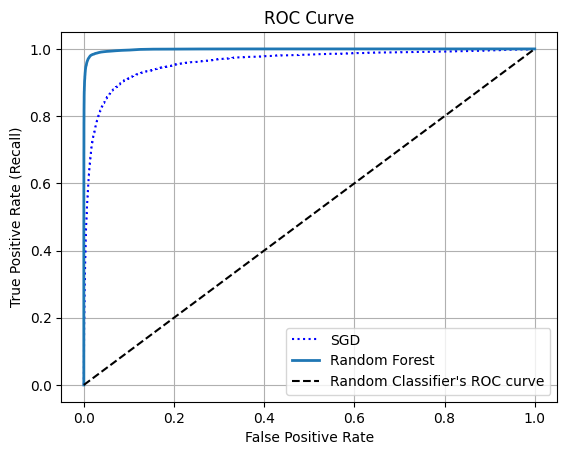

ROC AUC Score for RandomForestClassifier: 0.9983436731328145
Precision for RandomForestClassifier: 0.9897468089558485
Recall for RandomForestClassifier: 0.8725327430363402


In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Fungsi untuk memplot kurva ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier's ROC curve") # Garis diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid(True)
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

plot_roc_curve(fpr, tpr)
plt.show()

print(f"\nROC AUC Score for SGDClassifier: {roc_auc_score(y_train_5, y_scores)}")

# Membandingkan dengan RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # Skor = probabilitas kelas positif

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score for RandomForestClassifier: {roc_auc_score(y_train_5, y_scores_forest)}")

# Precision dan Recall untuk Random Forest
y_train_pred_forest = (y_probas_forest[:, 1] >= 0.5) # Menggunakan threshold default 0.5
print(f"Precision for RandomForestClassifier: {precision_score(y_train_5, y_train_pred_forest)}")
print(f"Recall for RandomForestClassifier: {recall_score(y_train_5, y_train_pred_forest)}")

### 4.Multiclass Classification (Klasifikasi Multikelas)

- Definisi: Pengklasifikasi multikelas (atau multinominal) dapat membedakan lebih dari dua kelas.
- Strategi:
  - One-versus-the-Rest (OvR) / One-versus-All: Melatih N pengklasifikasi biner (satu untuk setiap kelas). Saat mengklasifikasikan gambar, pilih kelas dengan skor tertinggi.
  - One-versus-One (OvO): Melatih pengklasifikasi biner untuk setiap pasangan kelas (N * (N-1) / 2 pengklasifikasi). Pilih kelas yang memenangkan duel paling banyak. Strategi ini disukai untuk algoritma yang tidak scale dengan baik terhadap ukuran training set (misalnya, SVM).
- Implementasi Scikit-Learn: Scikit-Learn secara otomatis menjalankan OvR atau OvO ketika algoritma klasifikasi biner digunakan untuk tugas multikelas.
  - Contoh: SVC (Support Vector Classifier) secara otomatis menggunakan strategi OvO.
  - SGDClassifier dan RandomForestClassifier secara alami dapat menangani banyak kelas.
- Evaluasi Multikelas: cross_val_score() dapat digunakan untuk mengevaluasi akurasi pengklasifikasi multikelas. Penskalaan input (StandardScaler) dapat secara signifikan meningkatkan akurasi.


In [8]:
from sklearn.svm import SVC

# Melatih SVC untuk klasifikasi multikelas
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train) # y_train, bukan y_train_5
print(f"\nSVC prediction for first digit: {svm_clf.predict([X_train.iloc[0].values])}")
print(f"SVC decision function scores for first digit:\n{svm_clf.decision_function([X_train.iloc[0].values])}")
print(f"SVC classes: {svm_clf.classes_}")

# Memaksa strategi OvR (ilustrasi)
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train, y_train)
print(f"\nOneVsRestClassifier prediction for first digit: {ovr_clf.predict([X_train.iloc[0].values])}")
print(f"Number of estimators (binary classifiers) in OvR: {len(ovr_clf.estimators_)}")

# Evaluasi SGDClassifier (naturally multiclass)
sgd_clf.fit(X_train, y_train)
print(f"\nSGDClassifier prediction for first digit: {sgd_clf.predict([X_train.iloc[0].values])}")
print(f"SGDClassifier decision function scores for first digit:\n{sgd_clf.decision_function([X_train.iloc[0].values])}")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) # Penskalaan
sgd_scores_scaled = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(f"SGDClassifier Accuracy (scaled data): {sgd_scores_scaled}")


SVC prediction for first digit: [5]
SVC decision function scores for first digit:
[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
SVC classes: [0 1 2 3 4 5 6 7 8 9]

OneVsRestClassifier prediction for first digit: [5]
Number of estimators (binary classifiers) in OvR: 10

SGDClassifier prediction for first digit: [3]
SGDClassifier decision function scores for first digit:
[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
SGDClassifier Accuracy (scaled data): [0.8983 0.891  0.9018]


### 5.Error Analysis (Analisis Kesalahan)

- Confusion Matrix (Visual): Matriks kebingungan divisualisasikan menggunakan matshow() dari Matplotlib untuk mengidentifikasi pola kesalahan.
- Analisis Tingkat Kesalahan: Dengan membagi setiap nilai dalam matriks kebingungan dengan jumlah gambar di kelas yang sesuai, tingkat kesalahan dapat dibandingkan.
- Wawasan dari Kesalahan: Matriks yang dinormalisasi menyoroti kelas-kelas yang sering salah diklasifikasikan (misalnya, digit 8 sering menjadi prediksi yang salah, dan digit 3 dan 5 sering tertukar). Wawasan ini dapat memandu perbaikan model, seperti mengumpulkan lebih banyak data pelatihan untuk kasus-kasus yang membingungkan atau merekayasa fitur baru (misalnya, menghitung jumlah closed loops pada digit).
- Analisis Kesalahan Individu: Melihat gambar-gambar yang salah diklasifikasikan secara individual dapat memberikan wawasan, meskipun lebih sulit dan memakan waktu.

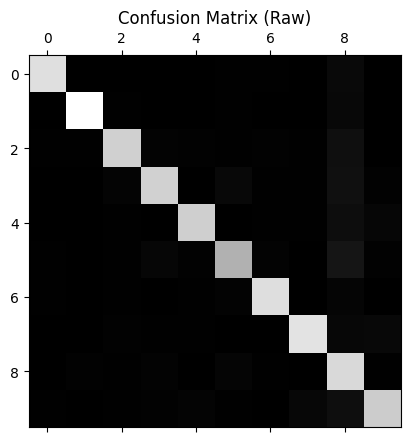

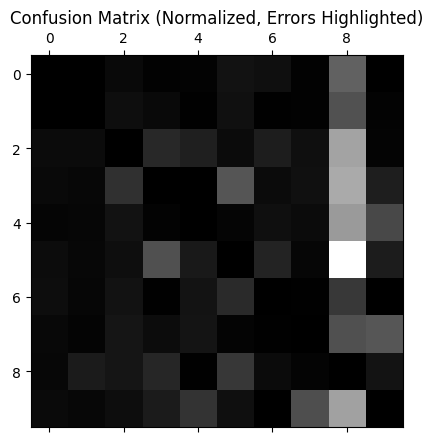

In [9]:
# 5. Error Analysis
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title("Confusion Matrix (Raw)")
plt.show()

# Normalisasi matriks kebingungan untuk melihat tingkat kesalahan
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Mengisi diagonal dengan nol untuk menyoroti kesalahan
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Confusion Matrix (Normalized, Errors Highlighted)")
plt.show()

# Contoh visualisasi digit yang salah diklasifikasikan (membutuhkan fungsi plot_digits dari notebook asli)
# Anda bisa melihat contoh visualisasi di notebook asli bab 3:
# https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb

### 6. Multilabel Classification (Klasifikasi Multilabel)

- Definisi: Sistem pengklasifikasi yang mengeluarkan beberapa label biner untuk setiap instansi.
- Contoh: Pengklasifikasi pengenalan wajah yang menandai beberapa orang dalam satu gambar.
- Implementasi: KNeighborsClassifier mendukung klasifikasi multilabel.
- Evaluasi: Evaluasi pengklasifikasi multilabel dapat dilakukan dengan menghitung F1 score untuk setiap label secara individual dan kemudian menghitung rata-ratanya (average="macro" atau average="weighted").

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Contoh multilabel classification: apakah digit besar (>=7) dan ganjil
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# Prediksi untuk digit pertama (label asli adalah 5)
print(f"\nKNeighborsClassifier multilabel prediction for first digit: {knn_clf.predict([X_train.iloc[0].values])}")

# Evaluasi multilabel classifier
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f"F1 score (macro average) for multilabel classifier: {f1_score(y_multilabel, y_train_knn_pred, average='macro')}")


KNeighborsClassifier multilabel prediction for first digit: [[False  True]]
F1 score (macro average) for multilabel classifier: 0.9764102655606048


### 7. Multioutput Classification (Klasifikasi Multioutput)

- Definisi: Generalisasi klasifikasi multilabel di mana setiap label bisa berupa multikelas (yaitu, memiliki lebih dari dua nilai yang mungkin).
- Contoh: Sistem penghilang noise gambar, di mana setiap piksel adalah label multikelas (intensitas piksel dari 0-255).
- Implementasi: Digunakan untuk melatih model yang mengambil gambar digit bising sebagai input dan mengeluarkan gambar digit bersih.

In [11]:
# 7. Multioutput Classification
# Membuat data bising untuk multioutput classification (denoising)
# X_train adalah DataFrame, perlu diubah ke numpy array jika belum
X_train_np = X_train.values
X_test_np = X_test.values

noise = np.random.randint(0, 100, (len(X_train_np), 784))
X_train_mod = X_train_np + noise
noise = np.random.randint(0, 100, (len(X_test_np), 784))
X_test_mod = X_test_np + noise
y_train_mod = X_train_np
y_test_mod = X_test_np

# Menampilkan gambar bising dan bersih (opsional, membutuhkan fungsi plot_digit)
# from chapter 3 original notebook for plot_digit
# some_index = 0
# plt.imshow(X_test_mod[some_index].reshape(28, 28), cmap="binary")
# plt.title("Noisy Image")
# plt.show()
# plt.imshow(y_test_mod[some_index].reshape(28, 28), cmap="binary")
# plt.title("Clean Target Image")
# plt.show()

# Melatih KNeighborsClassifier untuk multioutput classification
knn_clf.fit(X_train_mod, y_train_mod)
# clean_digit = knn_clf.predict([X_test_mod[some_index]])
# plt.imshow(clean_digit.reshape(28, 28), cmap="binary")
# plt.title("Cleaned Image by KNN")
# plt.show()

KNeighborsClassifier()

Konsep Kunci yang Dipelajari
- Klasifikasi Biner vs. Multikelas: Perbedaan dan strategi penanganan untuk setiap jenis tugas.
- Dataset yang Miring (Skewed Datasets): Pentingnya menggunakan metrik yang tepat selain akurasi untuk evaluasi.
- Metrik Evaluasi Pengklasifikasi:
  - Akurasi: Rasio prediksi yang benar; kurang andal untuk dataset yang miring.
  - Confusion Matrix: Memberikan gambaran rinci tentang True Positives, True Negatives, False Positives, dan False Negatives.
  - Precision: Ketepatan prediksi positif.
  - Recall (Sensitivity): Kemampuan model untuk menemukan semua instansi positif.
  - F1 Score: Rata-rata harmonis dari precision dan recall, menyeimbangkan keduanya.
- Precision/Recall Trade-off: Konsep dasar bahwa meningkatkan satu metrik seringkali mengurangi yang lain, dan bagaimana memilih threshold yang optimal berdasarkan kebutuhan bisnis.
- Kurva ROC (Receiver Operating Characteristic): Visualisasi True Positive Rate vs. False Positive Rate, dan ROC AUC Score sebagai metrik ringkasan.
- Klasifikasi Multilabel: Mengidentifikasi banyak label untuk satu instansi.
- Klasifikasi Multioutput: Setiap label keluaran dapat memiliki banyak nilai (misalnya, untuk denoising gambar).
- Scikit-Learn Tools: Penggunaan SGDClassifier, SVC, RandomForestClassifier, KNeighborsClassifier, cross_val_score, cross_val_predict, confusion_matrix, precision_score, recall_score, f1_score, dan roc_curve.
- Penskalaan Fitur: Pentingnya penskalaan data untuk algoritma seperti SGDClassifier.

## KESIMPULAN

Chapter 3 berhasil memberikan pengenalan mendalam tentang dunia klasifikasi Machine Learning, menyoroti tantangan unik yang muncul dibandingkan dengan regresi. Dengan penekanan pada metrik kinerja seperti precision, recall, F1 score, dan confusion matrix, pembaca dibekali dengan alat yang diperlukan untuk mengevaluasi pengklasifikasi secara kritis, terutama ketika berhadapan dengan dataset yang tidak seimbang. Diskusi tentang precision/recall trade-off dan kurva ROC juga sangat penting untuk pengambilan keputusan yang tepat dalam skenario nyata. Ini adalah bab fundamental yang membangun dasar untuk pemahaman lebih lanjut tentang model dan teknik ML.